In [79]:
import re
import datetime
import pandas as pd
import json
from osisoft.pidevclub.piwebapi.pi_web_api_client import PIWebApiClient
from pandasgui import show
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import os
from sklearn.model_selection import train_test_split
import scipy.stats as stats
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import roc_auc_score, auc, roc_curve
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import ConfusionMatrixDisplay, RocCurveDisplay
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
import pickle

In [53]:
df_nea_hora_con_ratios = pd.read_csv('df_nea_hora_con_ratios.csv')

In [54]:
df_nea_hora_con_ratios.set_index('Timestamp', inplace=True)

In [56]:
y = df_nea_hora_con_ratios['Colapso'].dropna()  # Drop rows with NaN values in the target variable

# Drop corresponding rows in the feature matrix
X = df_nea_hora_con_ratios.drop(['Colapso'], axis=1).loc[y.index]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, stratify=df_nea_hora_con_ratios['Colapso'])

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size= 0.1, shuffle=True, stratify=y_train)

print("Train:", len(X_train))
print("Tests:", len(X_test))
print("Validation:", len(X_val))

Train: 1120
Tests: 312
Validation: 125


In [57]:
X_train.replace([np.inf, -np.inf], np.nan, inplace=True)
X_train.fillna(0, inplace=True)

X_test.replace([np.inf, -np.inf], np.nan, inplace=True)
X_test.fillna(0, inplace=True)

X_val.replace([np.inf, -np.inf], np.nan, inplace=True)
X_val.fillna(0, inplace=True)

In [65]:
def evaluate_classification_model(X_train, y_train, X_val, y_val, X_test, y_test, Scale=False, Model='logistic'):
    if Scale:
        scaler = StandardScaler()
        X_train = scaler.fit_transform(X_train)
        X_val = scaler.transform(X_val)
        X_test = scaler.transform(X_test)

    if Model == 'logistic':
        model = LogisticRegression(max_iter=1000)
    elif Model == 'random_forest':
        model = RandomForestClassifier(criterion='entropy', max_depth=None, min_samples_split=2, min_samples_leaf=1, random_state=42)
    elif Model == 'gradient_boosting':
        model = GradientBoostingClassifier()
    elif Model == 'svm':
        model = SVC(kernel='linear', probability=True)
    elif Model == 'knn':  
        model = KNeighborsClassifier(n_neighbors=9, metric="minkowski", p=2)
    elif Model == 'decision_tree_classifier':  
        model = DecisionTreeClassifier(criterion='entropy', splitter='best', max_depth=None, min_samples_split=2, min_samples_leaf=1, random_state=42)
    else:
        raise ValueError("Model type not recognized")

    model.fit(X_train, y_train)
    y_pred_val = model.predict(X_val)
    y_pred_test = model.predict(X_test)

    #sns.histplot(data=y_pred_val)

    accuracy_val = accuracy_score(y_pred_val, y_val)
    precision_val = precision_score(y_pred_val, y_val, average='weighted')
    recall_val = recall_score(y_pred_val, y_val, average='weighted')
    f1_val = f1_score(y_pred_val, y_val, average='weighted')

    metrics_val_df = pd.DataFrame({
        'Modelo': [Model],
        'Scale': [Scale],
        'Accuracy': [accuracy_val],
        'Precision': [precision_val],
        'Recall': [recall_val],
        'F1': [f1_val]
    })

    # Calculamos la probabilidad del modelo
    prob_total = model.predict_proba(X_test)[:, -1] # para llevarlo a 1-d

    print(f"Informe de clasificación para el modelo {Model} en conjunto de prueba:")
    print(classification_report(y_test, y_pred_test))

    accuracy_test = accuracy_score(y_pred_test, y_test)

    return metrics_val_df

In [66]:
df_result = pd.DataFrame()

df_result = pd.concat([df_result, evaluate_classification_model(X_train, y_train, X_val, y_val, X_test, y_test, Scale=True, Model='logistic')], ignore_index=True)
df_result = pd.concat([df_result, evaluate_classification_model(X_train, y_train, X_val, y_val, X_test, y_test, Scale=True, Model='random_forest')], ignore_index=True)
df_result = pd.concat([df_result, evaluate_classification_model(X_train, y_train, X_val, y_val, X_test, y_test, Scale=True, Model='gradient_boosting')], ignore_index=True)
df_result = pd.concat([df_result, evaluate_classification_model(X_train, y_train, X_val, y_val, X_test, y_test, Scale=True, Model='svm')], ignore_index=True)
df_result = pd.concat([df_result, evaluate_classification_model(X_train, y_train, X_val, y_val, X_test, y_test, Scale=True, Model='knn')], ignore_index=True)
df_result = pd.concat([df_result, evaluate_classification_model(X_train, y_train, X_val, y_val, X_test, y_test, Scale=True, Model='decision_tree_classifier')], ignore_index=True)

print(df_result)

Informe de clasificación para el modelo logistic en conjunto de prueba:
              precision    recall  f1-score   support

           1       0.92      0.97      0.95       153
           2       0.97      0.92      0.94       154
         100       1.00      0.60      0.75         5

    accuracy                           0.94       312
   macro avg       0.96      0.83      0.88       312
weighted avg       0.94      0.94      0.94       312

Informe de clasificación para el modelo random_forest en conjunto de prueba:
              precision    recall  f1-score   support

           1       0.96      0.99      0.97       153
           2       0.98      0.95      0.97       154
         100       1.00      0.80      0.89         5

    accuracy                           0.97       312
   macro avg       0.98      0.91      0.94       312
weighted avg       0.97      0.97      0.97       312



c:\Users\CBureu\.virtualenvs\NEA-jRDK6KIF\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Informe de clasificación para el modelo gradient_boosting en conjunto de prueba:
              precision    recall  f1-score   support

           1       0.96      0.99      0.97       153
           2       0.99      0.95      0.97       154
         100       1.00      1.00      1.00         5

    accuracy                           0.97       312
   macro avg       0.98      0.98      0.98       312
weighted avg       0.97      0.97      0.97       312

Informe de clasificación para el modelo svm en conjunto de prueba:
              precision    recall  f1-score   support

           1       0.93      0.97      0.95       153
           2       0.97      0.94      0.95       154
         100       0.75      0.60      0.67         5

    accuracy                           0.95       312
   macro avg       0.88      0.83      0.86       312
weighted avg       0.95      0.95      0.95       312

Informe de clasificación para el modelo knn en conjunto de prueba:
              precision

c:\Users\CBureu\.virtualenvs\NEA-jRDK6KIF\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Informe de clasificación para el modelo decision_tree_classifier en conjunto de prueba:
              precision    recall  f1-score   support

           1       0.92      0.96      0.94       153
           2       0.97      0.92      0.94       154
         100       0.57      0.80      0.67         5

    accuracy                           0.94       312
   macro avg       0.82      0.89      0.85       312
weighted avg       0.94      0.94      0.94       312

                     Modelo  Scale  Accuracy  Precision  Recall        F1
0                  logistic   True     0.952   0.960400   0.952  0.955794
1             random_forest   True     0.960   0.960793   0.960  0.959830
2         gradient_boosting   True     0.960   0.976787   0.960  0.967767
3                       svm   True     0.936   0.937591   0.936  0.935814
4                       knn   True     0.928   0.944677   0.928  0.935311
5  decision_tree_classifier   True     0.936   0.937041   0.936  0.933792


Accuracy: 0.96
Precision: 0.9614769230769231
Recall: 0.96
F1 Score: 0.9601699199364786


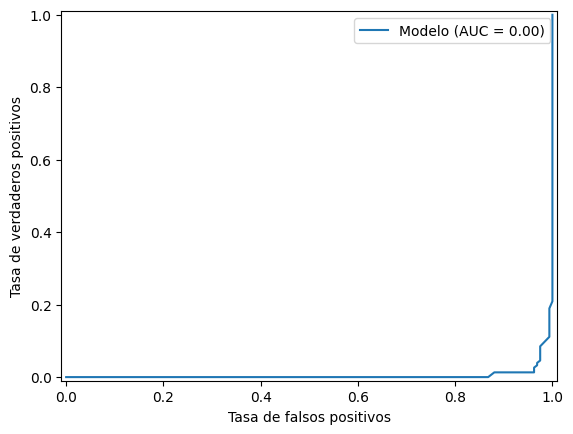

In [80]:
# Crear e entrenar el modelo RandomForestClassifier
model = RandomForestClassifier(criterion='entropy', max_depth=None, min_samples_split=2, min_samples_leaf=1, random_state=42)
model.fit(X_train, y_train)

pickle.dump(model, open('model.pkl', 'wb')) #save
 
# Predecir en los conjuntos de validación y prueba
y_pred_val = model.predict(X_val)
y_pred_test = model.predict(X_test)

# Calcular métricas de evaluación
accuracy_val = accuracy_score(y_val, y_pred_val)
precision_val = precision_score(y_val, y_pred_val, average='weighted')  # Para problemas multiclase, usa 'weighted'
recall_val = recall_score(y_val, y_pred_val, average='weighted')  # Para problemas multiclase, usa 'weighted'
f1_val = f1_score(y_val, y_pred_val, average='weighted')  # Para problemas multiclase, usa 'weighted'

# Calcular la probabilidad del modelo
if hasattr(model, 'decision_function'):
    scores = model.decision_function(X_test)
else:
    scores = model.predict_proba(X_test)[:, 1] 

# Realizar la curva ROC
fpr_total, tpr_total, _ = roc_curve(y_true=y_test, y_score=scores, pos_label=1)  
roc_auc = auc(fpr_total, tpr_total)

# Ploteamos la curva ROC
plt.plot(fpr_total, tpr_total, label=f"Modelo (AUC = {roc_auc:.2f})")
plt.xlim([-0.01, 1.01])
plt.ylim([-0.01, 1.01])
plt.xlabel("Tasa de falsos positivos")
plt.ylabel("Tasa de verdaderos positivos")
plt.legend()

# Mostrar métricas
print(f"Accuracy: {accuracy_val}")
print(f"Precision: {precision_val}")
print(f"Recall: {recall_val}")
print(f"F1 Score: {f1_val}")

# Mostrar la curva ROC
plt.show()


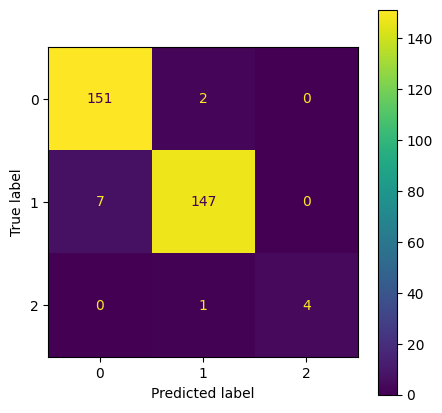

In [75]:
cm = confusion_matrix(y_test, y_pred_test)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)

fig, ax = plt.subplots(figsize=(5,5))
ax.grid(False)
disp.plot(ax=ax);